In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
from pylab import rcParams
import math
from lstm_utils import *


# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(1)
print(tf.__version__)
tf.random.set_seed(0)

2.1.0


In [3]:
tf.keras.backend.clear_session()

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
parent_dir = os.path.dirname(os.getcwd())
train_file = os.path.join(parent_dir, 'CMAPSS_Data', 'train_FD001.txt')
test_file = os.path.join(parent_dir, 'CMAPSS_Data', 'test_FD001.txt')
rul_file = os.path.join(parent_dir, 'CMAPSS_Data','RUL_FD001.txt')
weight_path = os.path.join(parent_dir, 'weights')

In [6]:
raw_train_df = pd.read_csv(train_file, sep=r"\s+", header=None)
raw_test_df = pd.read_csv(test_file , sep=r"\s+", header=None)
rul_df = pd.read_csv(rul_file, sep=r"\s+", header=None)
print(raw_train_df.shape)
print(raw_test_df.shape)
print(rul_df.shape)

(20631, 26)
(13096, 26)
(100, 1)


In [7]:
columns = ['unit_number','time_in_cycles','op_set_1','op_set_2','op_set_3','sm_1','sm_2','sm_3','sm_4','sm_5','sm_6','sm_7',
           'sm_8','sm_9','sm_10','sm_11','sm_12','sm_13','sm_14','sm_15','sm_16','sm_17','sm_18','sm_19','sm_20','sm_21']
raw_train_df.columns = columns
raw_test_df.columns = columns

In [8]:
raw_train_df.head()

,unit_number,time_in_cycles,op_set_1,op_set_2,op_set_3,sm_1,sm_2,sm_3,sm_4,sm_5,sm_6,sm_7,sm_8,sm_9,sm_10,sm_11,sm_12,sm_13,sm_14,sm_15,sm_16,sm_17,sm_18,sm_19,sm_20,sm_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [9]:
train_df = prepare_train_dataset(raw_train_df)
print(train_df.shape)
train_df.head()

(20631, 17)


,unit_number,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21,rul
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


In [10]:
test_df = prepare_test_dataset(raw_test_df)
print(test_df.shape)
test_df.head()

(13096, 16)


,unit_number,time_in_cycles,sm_2,sm_3,sm_4,sm_6,sm_7,sm_8,sm_9,sm_11,sm_12,sm_13,sm_15,sm_17,sm_20,sm_21
0,1,1,643.02,1585.29,1398.21,21.61,553.90,2388.04,9050.17,47.20,521.72,2388.03,8.4052,392,38.86,23.3735
1,1,2,641.71,1588.45,1395.42,21.61,554.85,2388.01,9054.42,47.50,522.16,2388.06,8.3803,393,39.02,23.3916
2,1,3,642.46,1586.94,1401.34,21.61,554.11,2388.05,9056.96,47.50,521.97,2388.03,8.4441,393,39.08,23.4166
3,1,4,642.44,1584.12,1406.42,21.61,554.07,2388.03,9045.29,47.28,521.38,2388.05,8.3917,391,39.00,23.3737
4,1,5,642.51,1587.19,1401.92,21.61,554.16,2388.01,9044.55,47.31,522.15,2388.03,8.4031,390,38.99,23.4130


In [11]:
print(rul_df.shape)
rul_df.head()

(100, 1)


,0
0,112
1,98
2,69
3,82
4,91


In [12]:
seq_array, label_array, lstm_test_df, sequence_length, sequence_cols = lstm_preprocessing(train_df, test_df, rul_df)

In [13]:
model = lstm_model(seq_array, label_array, sequence_length)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           46000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 76,251
Trainable params: 76,251
Non-trainable params: 0
__________________________________________________

In [14]:
callbacks = [tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=3, restore_best_weights=True)]
history = model.fit(seq_array, label_array, epochs=100, batch_size=128, validation_split=0.05, verbose=1, callbacks=callbacks)

Train on 14849 samples, validate on 782 samples
Epoch 1/100
14849/14849 [==============================] - 7s 492us/step - loss: 8959.7169 - mae: 76.0887 - R2: -27125280.0000 - val_loss: 8062.7320 - val_mae: 71.3166 - val_R2: -4.5935
Epoch 2/100
14849/14849 [==============================] - 7s 438us/step - loss: 7812.1019 - mae: 69.3679 - R2: -63310552.0000 - val_loss: 7237.8924 - val_mae: 66.5416 - val_R2: -5.2464
Epoch 3/100
14849/14849 [==============================] - 7s 446us/step - loss: 7058.1358 - mae: 65.0718 - R2: -909277824.0000 - val_loss: 6550.7497 - val_mae: 62.6030 - val_R2: -6.4659
Epoch 4/100
14849/14849 [==============================] - 7s 444us/step - loss: 6412.3036 - mae: 61.4110 - R2: -179433424.0000 - val_loss: 5960.8997 - val_mae: 59.2609 - val_R2: -8.1611
Epoch 5/100
14849/14849 [==============================] - 7s 447us/step - loss: 5860.6638 - mae: 58.3399 - R2: -555389568.0000 - val_loss: 5454.9121 - val_mae: 56.4319 - val_R2: -10.2516
Epoch 6/100
14849/

MAE: 12.08
R^2: 0.85


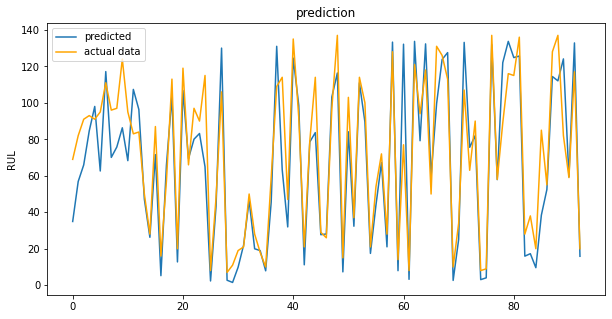

In [15]:
MAE, R2 = test_model(lstm_test_df, model, sequence_length, sequence_cols)

In [17]:
model.save(os.path.join(weight_path, 'lstm_regression.h5'))
print ('Saved trained model at {}'.format(os.path.join(weight_path, 'lstm_regression.h5')))

Saved trained model at D:\Projects\machine_failure\weights\lstm_regression.h5
